## Energy evaluation for model graph

#### Considero il modello di una rete neurale (sequenziale) come un grafo pesato.
#### I pesi assegnati al grafo sono considerati tenendo conto dei pesi $x^{l-1}_{i}\cdot W^{l}_{i,j}$ del layer $l$.
#### I pesi del grafo dipendono quindi dal punto.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
tf.keras.backend.set_floatx('float64')
import copy
from tqdm import tqdm
from ModelGraph import ModelGraph
from DataSet import DataSet

#### Instanzio la classe DataSet contenente metodi per instanziare dataset di test

In [2]:
dataset=DataSet()

In [3]:
X=dataset.generate_circles_set()

(-1.0, 1.0, -1.0, 1.0)

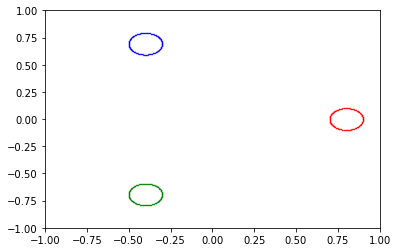

In [4]:
plt.scatter(X[:200,0],X[:200,1],s=.1,c='red')
plt.scatter(X[200:400,0],X[200:400,1],s=.1,c='blue')
plt.scatter(X[400:600,0],X[400:600,1],s=.1, c='green')
plt.axis([-1,1,-1,1])

#### Creo un set di configurazioni dei layer interni

In [5]:
# internal node configuration
model_configurations=[
    [4],
    [8],
    [3],
    [8,4,8],
    [16,4,16],
    [16,8,16],
    [6,3,6]
]

#### Instanzio i modelli di test con le configurazioni definite sopra

In [6]:
models=[]
for configuration in model_configurations:
    input=tf.keras.layers.Input(shape=(2,),dtype=tf.float64)
    p=input
    for n_neuron in configuration:
        p=tf.keras.layers.Dense(n_neuron,activation='tanh',dtype=tf.float64)(p)
    output=tf.keras.layers.Dense(2,activation='tanh',dtype=tf.float64)(p)
    model=tf.keras.models.Model(input,output)
    model.compile(optimizer="Adam", loss="mse")
    models.append(model)

2022-07-23 09:49:40.115427: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-23 09:49:40.115833: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 12. Tune using inter_op_parallelism_threads for best performance.


#### Addestro i modelli. Registro i modelli in fase di addestramento

In [7]:
model_graphs={}
history={}

for model_id in range(len(models)):
    history[model_id]=[]
    model_graphs[model_id]=[]
    total_epochs=5000
    epochs=100
    pbar=tqdm(total=int(total_epochs/epochs))
    while total_epochs>0:
        history[model_id].append(models[model_id].fit(X,X,epochs=epochs,verbose=0))
        model_graphs[model_id].append(ModelGraph(models[model_id]))
        total_epochs=total_epochs-epochs
        pbar.update(1)
    pbar.close()

100%|███████████████████████████████████████████| 50/50 [02:33<00:00,  3.06s/it]


#### Eseguo il plot della loss

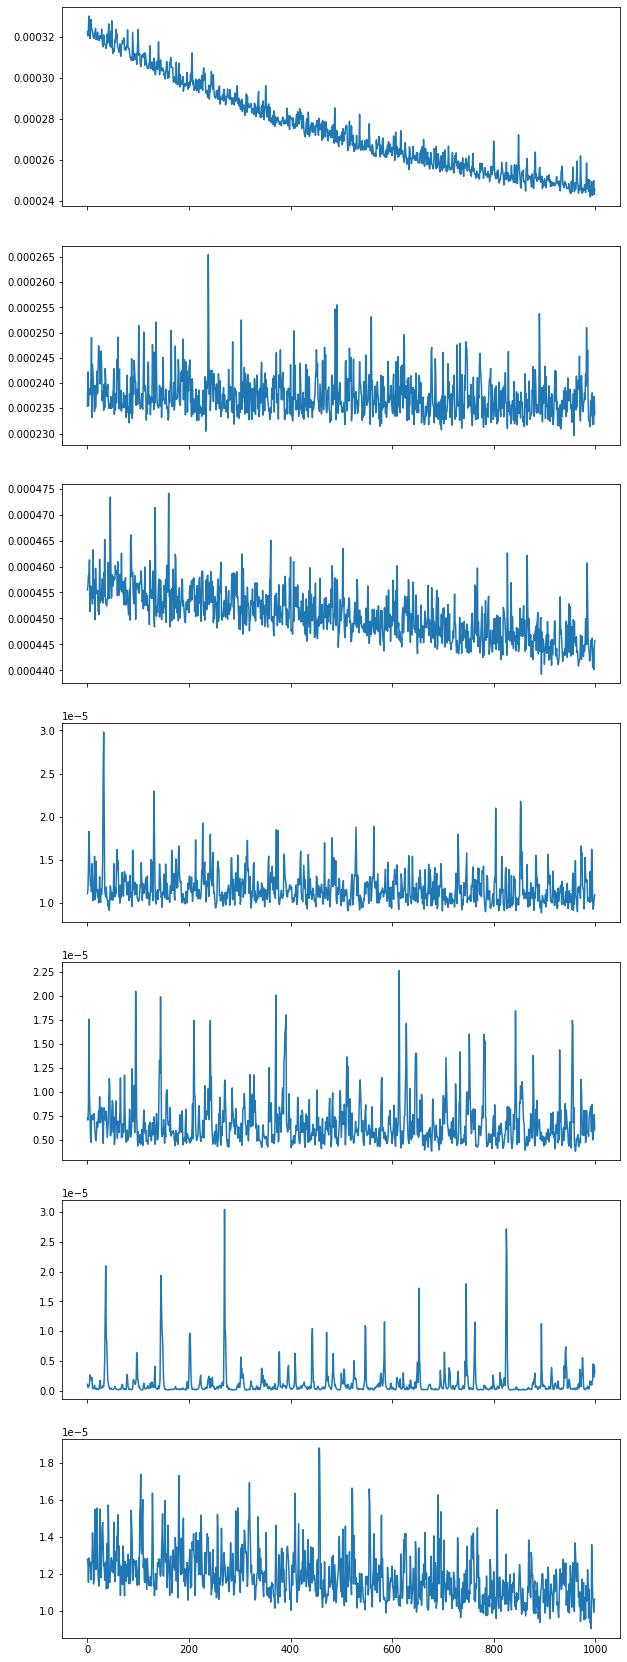

In [13]:
f, ax = plt.subplots(len(list(history.keys())), 1, sharex=True, figsize=(10,30))
m_id=0
for model_id in history.keys():
    t_h=[]
    for h in history[model_id]:
        t_h.extend(h.history['loss'])
    ax[m_id].plot(range(len(t_h)-4000),t_h[4000:])
    m_id+=1

#### Per ogni configurazione e per ogni snapshot del modello calcolo l'energia in ogni punto.
#### L'energia del grafo è definita come $$E=\sum_{\lambda\in spectr(A)}|\Re{\lambda}|$$
#### dove A è la matrice di adiacenza

In [14]:
E={}
for model_id in model_graphs.keys():
    E[model_id]=[]
    pbar=tqdm(total=len(model_graphs[model_id]))
    for mg in model_graphs[model_id]:
        E[model_id].append([mg.compute_energy(x) for x in X])
        pbar.update(1)
    pbar.close()

100%|███████████████████████████████████████████| 50/50 [00:13<00:00,  3.81it/s]


#### L'Energia sembra tendere ad un livello di energia limite che dipende dalla configurazione della rete (da dimostrare)

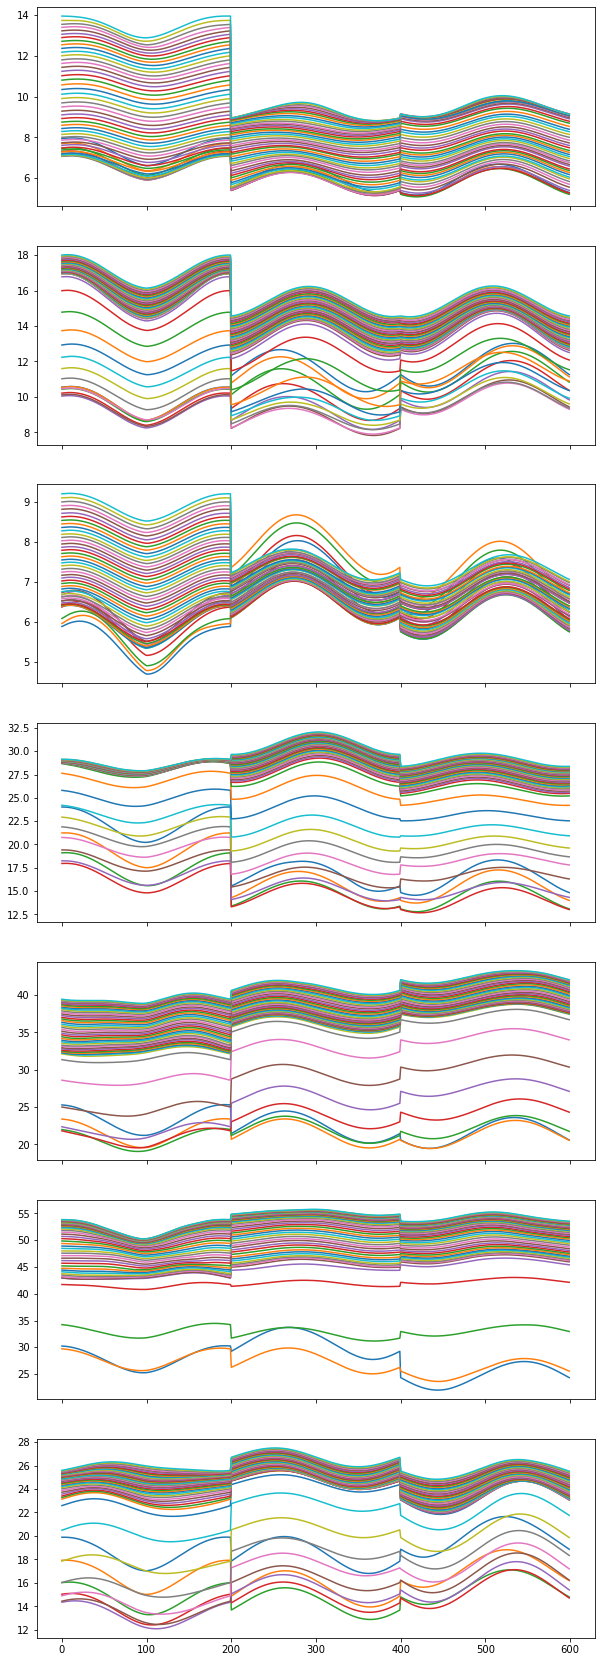

In [20]:
f, ax = plt.subplots(len(list(E.keys())), 1, sharex=True, figsize=(10,30))
m_id=0
for model_id in E.keys():
    for Eh in E[model_id]:
        ax[m_id].plot(range(len(Eh)),Eh)
    m_id+=1


#### A livelli di energia più alta corrisponde una maggiore accuratezza del modello.(da dimostrare. Verificare i livelli di energia in overfitting)

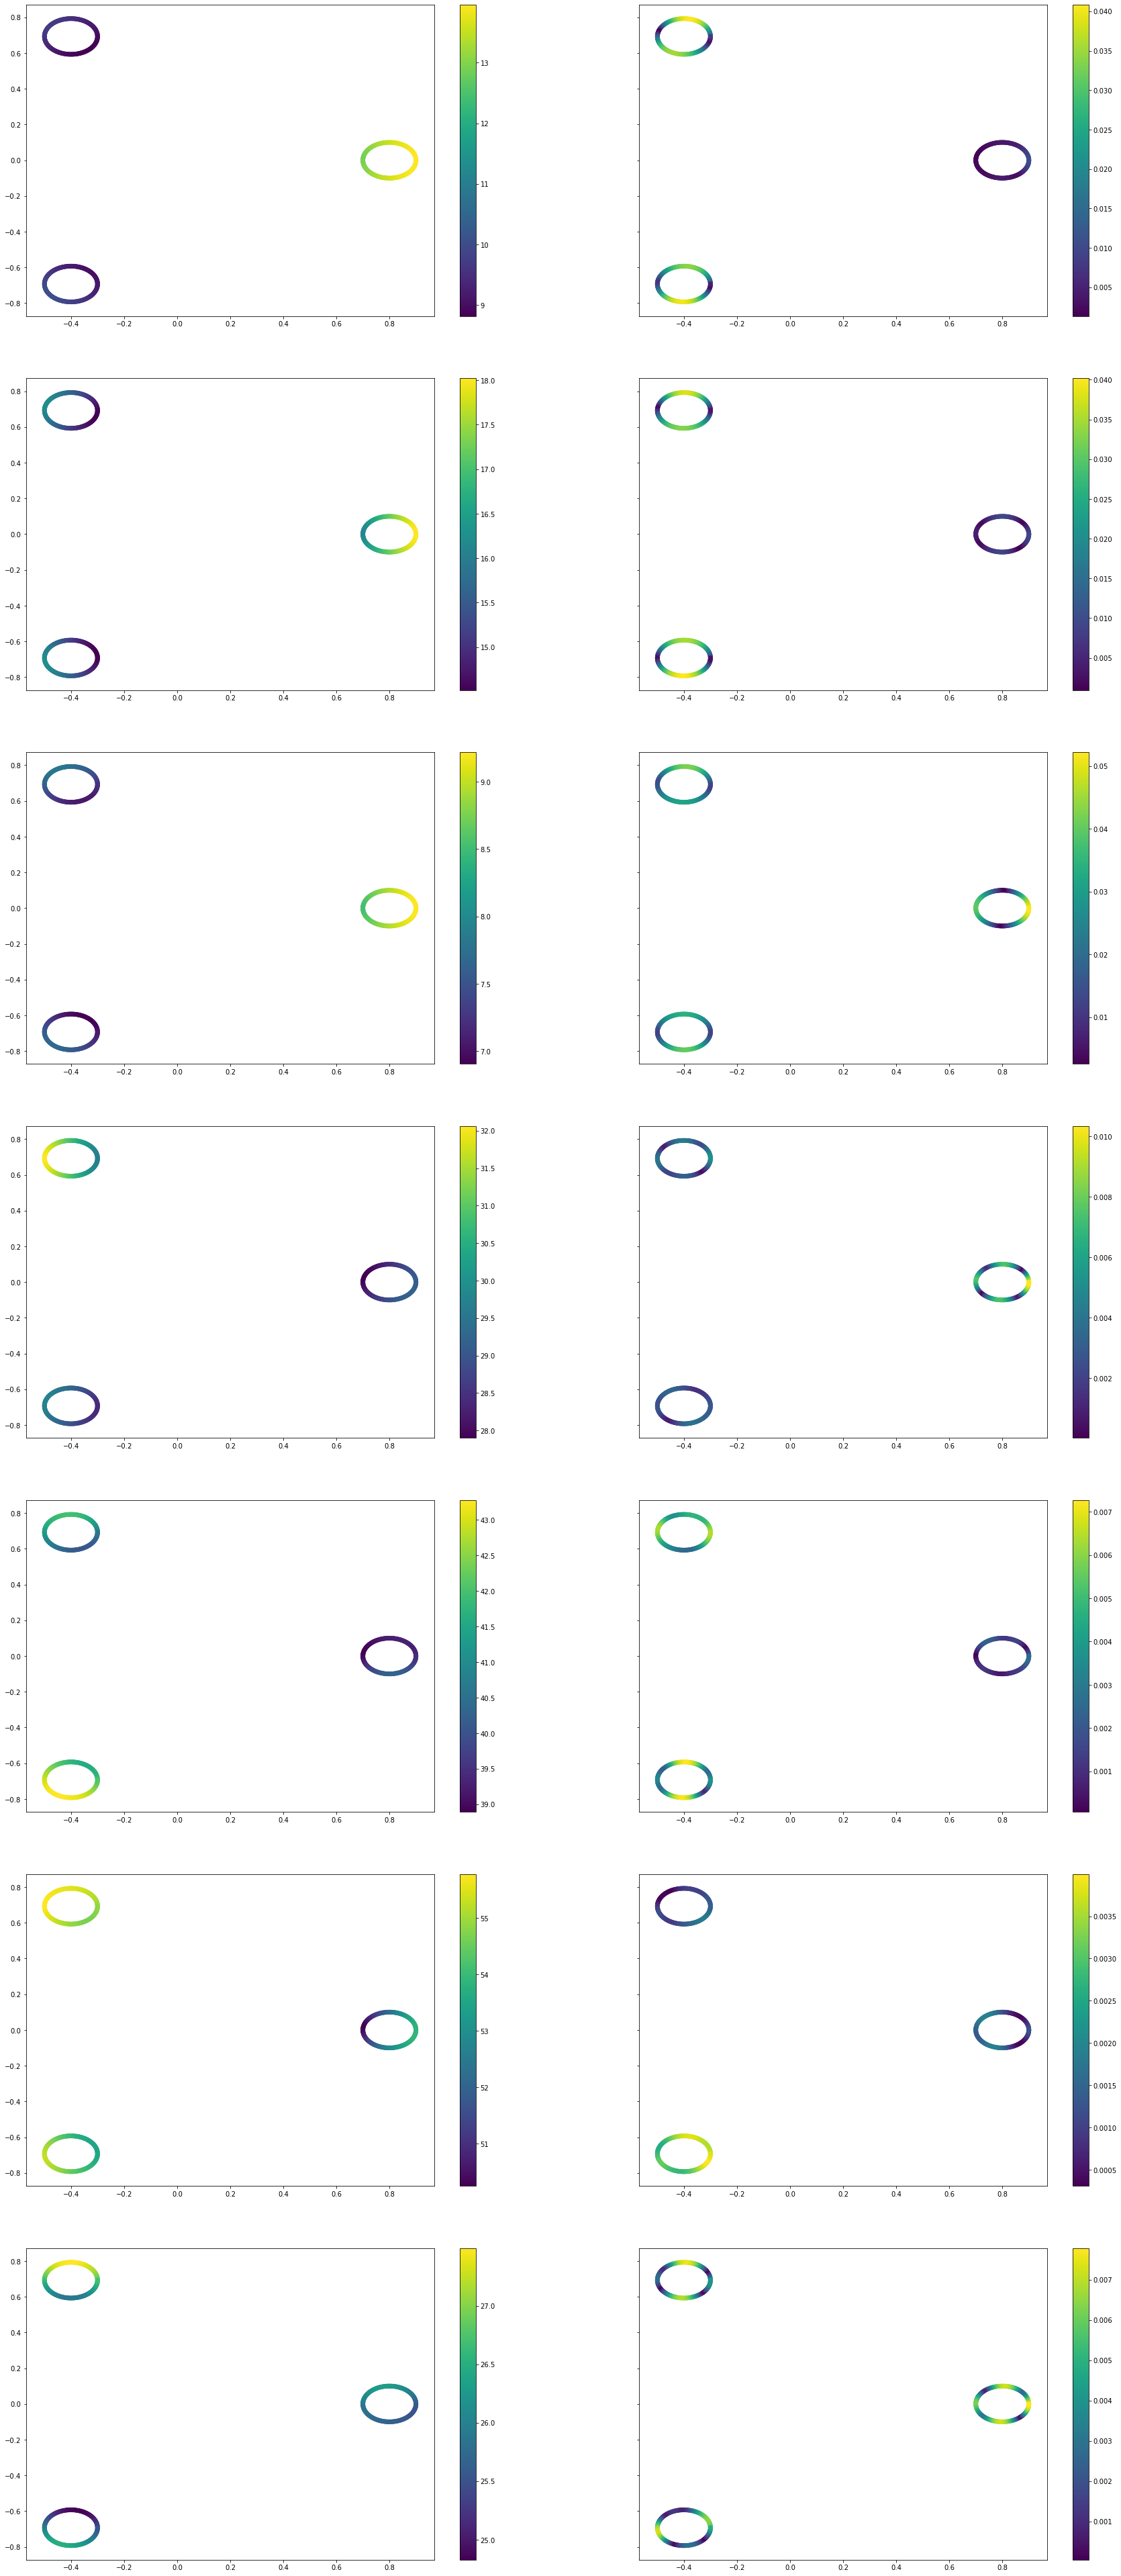

In [60]:
f, ax = plt.subplots(len(list(E.keys())), 2, sharey=True, figsize=(30,10*len(list(E.keys()))))
m_id=0
for model_id in history.keys():
    scat=ax[m_id,0].scatter(X[:,0],X[:,1],c=E[model_id][-1],cmap="viridis")
    plt.colorbar(scat,ax=ax[m_id,0])
    errors=np.linalg.norm(model_graphs[model_id][-1].predict(X)-X,axis=1)
    scat1=ax[m_id,1].scatter(X[:,0],X[:,1],c=errors,cmap="viridis")
    plt.colorbar(scat1,ax=ax[m_id,1])
    m_id+=1

In [ ]:
import gudhi as gd

In [ ]:
st = gd.SimplexTree()

In [ ]:
for t,v in zip(model_graphs[-1].E,model_graphs[-1].compute_edges(X[0])):
    st.assign_filtration(t,abs(v))